# Toliman model fitting
---
## Crawl:
- Fit single Zemax PSF with FT to test centroid offsets

It seems that we can fit the the Zemax psf very well but we cannot know the precision of the fit without knowing the centroid offset between the two methods.

In [1]:
import numpy as np
import json
from scipy import ndimage
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from tqdm.auto import tqdm
from scipy.optimize import least_squares, minimize

from lib.formatter import *
from lib.conversions import *
from lib.detector_modelling import *
from lib.FT_modelling import *
from lib.FT_model_fitting import *
from lib.synphot import *

# tqdm spacing workaround
from IPython.core.display import HTML
HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
</style>
""")

In [140]:
# Optical Architecture
sim_vals = {
    # Optical Architecture
    "aperture": 0.1, # m
    "m2_obsc": 0.011, # m, diameter
    "focal_length": 3.635, # m
    "wavelength": 595e-9, # Central wavelength

    # CCD Architecture
    "detector_size": 200,
    "detector_pitch": 6.5e-6,
    
    # Simulation Parameters
    "transform_size": 2**10
    "zmx_pixel": 1.625e-6
    
    # Currently irrelevant
#     "fps": 7.5
#     "QE": 0.9
#     "read_noise": 1.6
#     "dark_current": 0.68
#     "gain": 1.29
#     "full_well": 95e3
    
}

# write
with open("simulation_values.txt", 'w') as f:
    json.dump(sim_vals, f)
    
# read
with open("simulation_values.txt") as f:
    data = json.load(f)

In [3]:
# Save the pupil file
pupil = pupil_from_fits("files/pupil_new_2k.fits")
np.save("pupil_array", pupil)

In [4]:
# Zemax settings
zmx_pixel_size = 1.625e-6

In [5]:
# Load Zemax PSF
psf_zmx, psf_on_meta_data_zmx = zemax_to_array('files/on-axis_monochromatic_595.txt')

In [6]:
size_ratio = zmx_pixel_size/sim_vals["detector_pitch"]
c = int(psf_zmx.shape[0]//2)
s = int((sim_vals["detector_size"]/2) /size_ratio)
zmx_im = psf_zmx[c-s:c+s, c-s:c+s]
np.save("zmx_im", zmx_im)

In [7]:
# Downsample to detector (on-axis), normalise, take central area and save

# im_zoom = ndimage.zoom(psf_zmx, size_ratio)
# im = im_zoom/np.sum(im_zoom)
# c = im.shape[0]//2
# s = int(sim_vals["detector_size"]//2)
# im = im[c-s:c+s, c-s:c+s]
# np.save("zmx_im", im)

In [86]:
im_zoom = ndimage.zoom(zmx_im, size_ratio)
im = im_zoom/np.sum(im_zoom)
np.save("zmx_zoom", im)
psf = build_model_cartesian([0,0])
diff = np.square(im - psf)

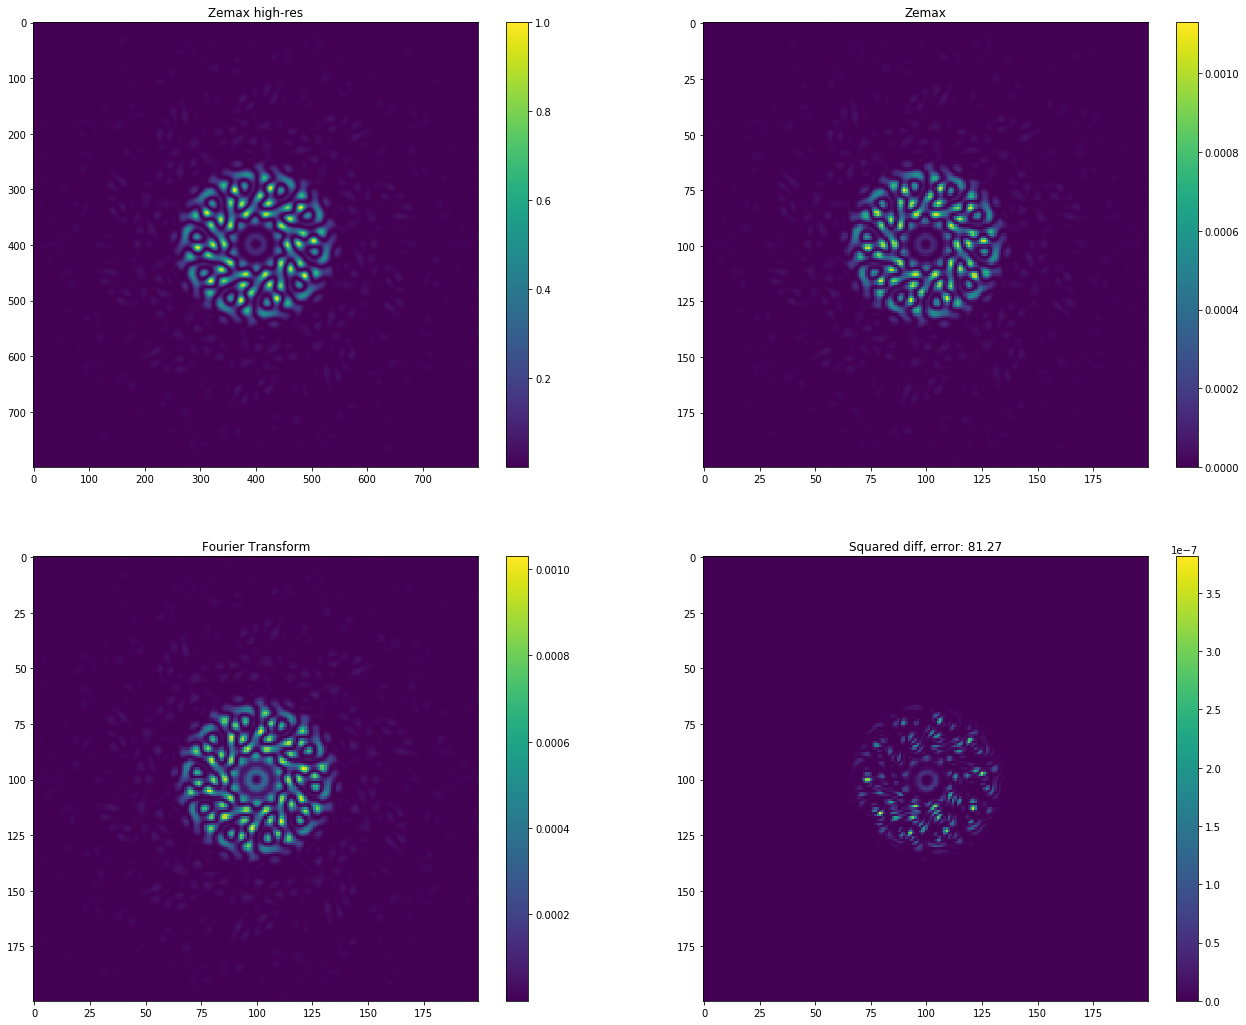

In [87]:
# Test to see everything looks normal
plt.figure(figsize=(22, 18))

plt.subplot(2, 2, 1)
plt.title("Zemax high-res")
plt.imshow(zmx_im)
plt.colorbar()

plt.subplot(2, 2, 2)
plt.title("Zemax")
plt.imshow(im)
plt.colorbar()

plt.subplot(2, 2, 3)
plt.title("Fourier Transform")
plt.imshow(psf)
plt.colorbar()

plt.subplot(2, 2, 4)
plt.title("Squared diff, error: {:.2f}".format(np.sum(diff)*1e6))
plt.imshow(diff)
plt.colorbar()

plt.show()

---
## Test sub pixel shifting

      fun: 2.279629593865732e-05
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.39131801e-06, -3.96894940e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 9
      nit: 2
   status: 0
  success: True
        x: array([-0.36424963,  0.60607442])


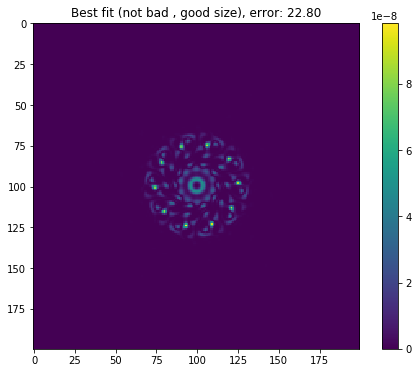

In [90]:
# Set starting values 
central_fit = minimize(evaluate_model, [0, 0], method="L-BFGS-B")#, options={"ftol": 1e-10})
print(central_fit)
x0 = central_fit.x

im_out = build_model_cartesian(x0)
diff_new = np.square(im - im_out)
plt.figure(figsize=(8,6))
plt.imshow(diff_new)
plt.title("Best fit (not bad , good size), error: {:.2f}".format(np.sum(diff_new)*1e6))
plt.colorbar()
plt.show()

In [11]:
num_shifts = 25
max_val = 0.1

---
### Randomly sample from the cartesian plane

In [12]:
# Create a random sample of xy shifts each within the range 0-0.1
shifts = np.random.random_sample([num_shifts, 2]) * max_val
x_in = shifts[:, 0]
y_in = shifts[:, 1]

---
### Linear distrbution in r, random sample in phi (polar)

In [13]:
rs = np.linspace(0, max_val, num=num_shifts, endpoint=False).reshape(num_shifts, 1)
phis = np.random.random_sample([num_shifts, 1]) * 2*np.pi
x_in = rs*np.cos(phis)
y_in = rs*np.sin(phis)
shifts = np.concatenate((x_in, y_in), axis=1)
x_in = x_in.reshape(num_shifts)
y_in = y_in.reshape(num_shifts)

In [81]:
%%time
x_out = np.zeros(num_shifts)
y_out = np.zeros(num_shifts)
errors = np.zeros(num_shifts)
iters = np.zeros(num_shifts)
fevs = np.zeros(num_shifts)

for i in tqdm(range(num_shifts)):
    # Shift and save zmx psf, linear interpolation
    
    # Shift high res zmx
    shift = shifts[i]/size_ratio
    zmx_shift = ndimage.shift(zmx_im, shift, order=3) # Spline interpolation for zemax shift (should be up 1/2 pixel for 0.1 detector pixels)
    
    # Downsample and normalise to detector
    im_shift = ndimage.zoom(zmx_shift, size_ratio)
    im_shift = im_shift/np.sum(im_shift)
    
    # Save the shifted image for model fitting
    np.save("zmx_shift", im_shift)

    # Fit the model and save the shift value
    out = minimize(evaluate_model_shift, x0)
    
    # Save meta data
    errors[i] = out.fun
    iters[i] = out.nit
    fevs[i] = out.nfev
    
    # Get the output shift values 
    x_out[i] = shifts[i][0] + x0[0] - out.x[0]
    y_out[i] = shifts[i][1] + x0[1] - out.x[1]

#     x_out[i] = out.x[0] - x0[0]
#     y_out[i] = out.x[1] - x0[1]


CPU times: user 2min 24s, sys: 20.2 s, total: 2min 44s
Wall time: 1min 26s


In [110]:
deltas_in = np.hypot(x_in.reshape(num_shifts), y_in.reshape(num_shifts))
deltas_out = np.hypot(x_out, y_out)

order = np.argsort(deltas_out)
order_x = np.argsort(x_in)
order_y = np.argsort(y_in)

In [111]:
d_in_sort = deltas_in[order]
d_out_sort = deltas_out[order]
lin_d = np.linspace(0, np.hypot(max_val, max_val), num=num_shifts, endpoint=False)

errors_sort = errors[order]
iters_sort = iters[order]
fevs_sort = fevs[order]

x_in_sort = x_in[order]
x_out_sort = x_out[order]
lin_x = np.linspace(-max_val, max_val, num=num_shifts*2, endpoint=False)

y_in_sort = y_in[order]
y_out_sort = y_out[order]
lin_y = np.linspace(-max_val, max_val, num=num_shifts*2, endpoint=False)

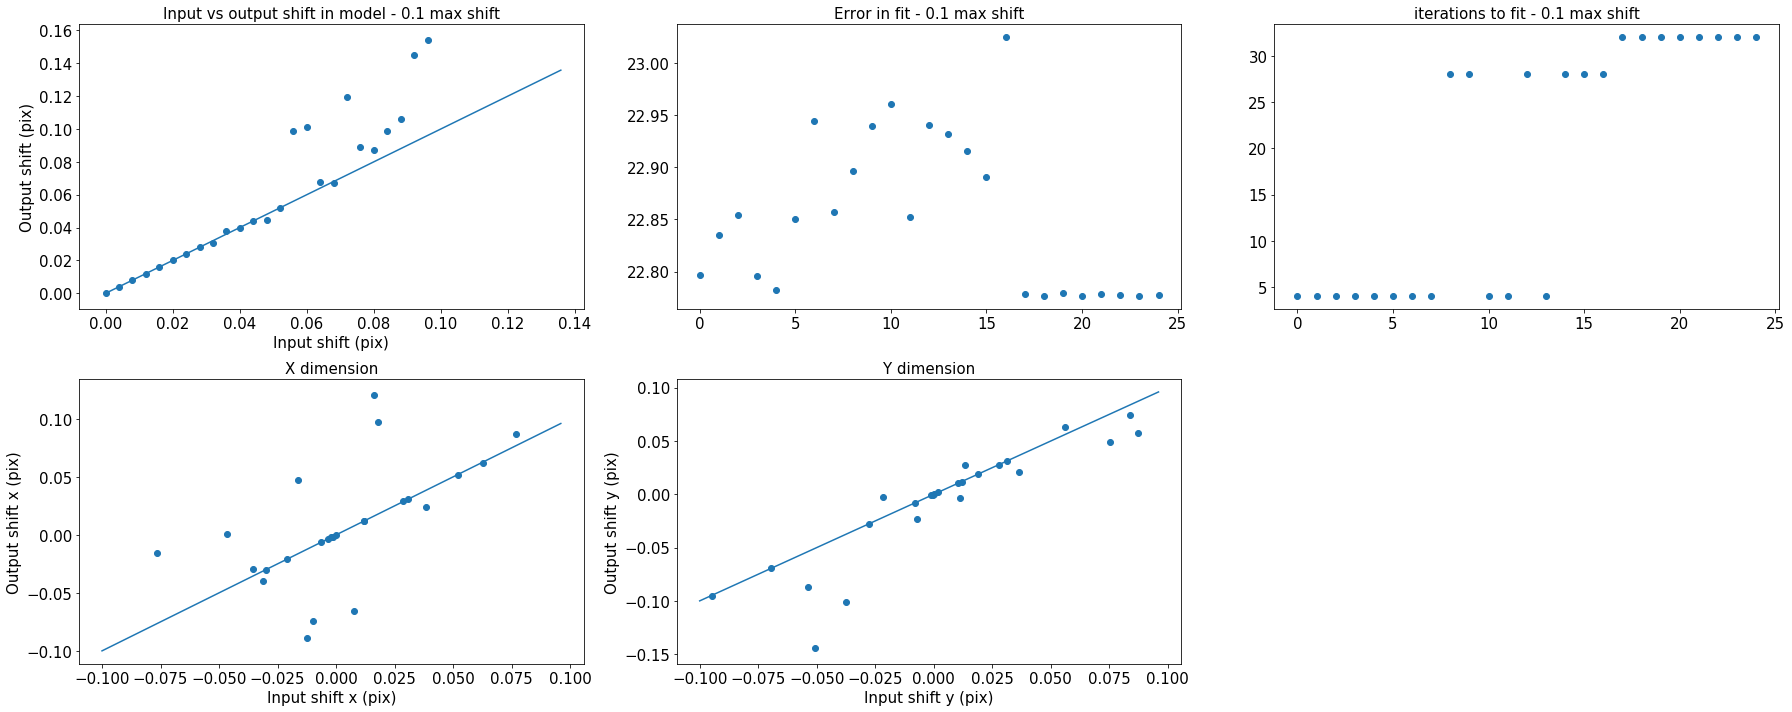

In [121]:
plt.figure(figsize=(25, 10))
plt.subplot(2, 3, 1)
plt.title("Input vs output shift in model - 0.1 max shift", fontsize=15)
plt.plot(lin_d, lin_d)
plt.scatter(deltas_in, deltas_out)
plt.xlabel("Input shift (pix)", fontsize=15)
plt.ylabel("Output shift (pix)", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(2, 3, 2)
plt.title("Error in fit - 0.1 max shift", fontsize=15)
plt.plot(errors_sort*1e6, 'C0o')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(2, 3, 3)
plt.title("iterations to fit - 0.1 max shift", fontsize=15)
# plt.plot(iters_sort, 'C0o')
plt.plot(fevs_sort, 'C0o')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(2, 3, 4)
plt.title("X dimension", fontsize=15)
plt.plot(lin_x, lin_x)
plt.scatter(x_in, x_out)
plt.xlabel("Input shift x (pix)", fontsize=15)
plt.ylabel("Output shift x (pix)", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(2, 3, 5)
plt.title("Y dimension", fontsize=15)
plt.plot(lin_y, lin_y)
plt.scatter(y_in, y_out)
plt.xlabel("Input shift y (pix)", fontsize=15)
plt.ylabel("Output shift y (pix)", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
plt.show()

In [114]:
max_diff_idx = 0
worst = 0

for i in range(num_shifts):
    dxi = x_in[i]*1e3
    dxo = x_out[i]*1e3
    dx = dxi-dxo
    if dx < 1e-10 and dx > -1e-10:
        dx = 0
    
    dyi = y_in[i]*1e3
    dyo = y_out[i]*1e3
    dy = dyi-dyo
    if dy < 1e-10 and dy > -1e-10:
        dy = 0
    
    dri = np.hypot(dxi, dyi)
    dro = np.hypot(dxo, dyo)
    dr = dri-dro
    
    if np.abs(dr) > worst:
        worst = np.abs(dr)
        max_diff_idx = i
    
#     print("R: in: {:.2f}\t out: {:.2f}\t diff: {:.2f}".format(dri, dro, dr))
#     print("X: in: {:.2f}\t out: {:.2f}\t diff: {:.2f}".format(dxi, dxo, dx))
#     print("Y: in: {:.2f}\t out: {:.2f}\t diff: {:.2f}".format(dyi, dyo, dy))
#     print()

In [123]:
print(order[16])
# print(max_diff_idx)
# print(order)

20


---
Now plot the diff to see why it doesnt fit well

In [132]:
# Shift high res zmx
shift = shifts[20]/size_ratio
zmx_shift = ndimage.shift(zmx_im, shift, order=3) # Spline interpolation for zemax shift (should be up 1/2 pixel for 0.1 detector pixels)

# Downsample and normalise to detector
im_shift = ndimage.zoom(zmx_shift, size_ratio)
im_shift = im_shift/np.sum(im_shift)

# Save the shifted image for model fitting
np.save("zmx_shift", im_shift)

out = minimize(evaluate_model_shift, x0)

In [133]:
fit = out.x
print(shift)
print(fit)

[ 0.30785824 -0.08731153]
[-0.37444647  0.58704935]


In [137]:
# fit = [x_out[max_diff_idx], y_out[max_diff_idx]]
im_fit = build_model_cartesian(fit)
diff = np.square(im_shift - im_fit)

theoretical_model = build_model_cartesian(fit)
diff_theory = np.square(im_shift - theoretical_model)

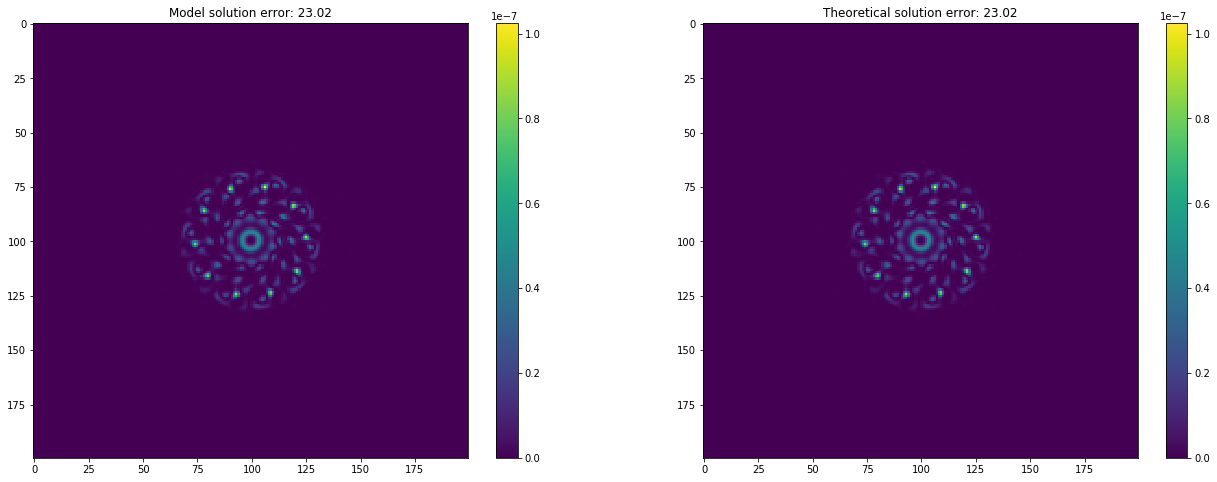

In [138]:
# Test to see everything looks normal
plt.figure(figsize=(22, 8))

plt.subplot(1, 2, 1)
plt.title("Model solution error: {:.2f}".format(np.sum(diff)*1e6))
plt.imshow(diff)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Theoretical solution error: {:.2f}".format(np.sum(diff_theory)*1e6))
plt.imshow(diff_theory)
plt.colorbar()

plt.show()


---

Now try optimising from this position to see if it can find a better fit